In [1]:
from resample.bootstrap import jackknife
import numpy as np
import numba as nb
from typing import Callable, Optional, Tuple
from timeit import timeit
from matplotlib import pyplot as plt

In [2]:
@nb.njit(nogil=True)
def _jackknife_jit(a: np.ndarray):
    n = len(a)
    x = np.empty((n, n - 1), dtype=a.dtype)
    for i in range(n):
        for j in range(n-1):
            shift = 0 if j < i else 1
            x[i, j] = a[j + shift]
    return x


def jackknife_jit(a: np.ndarray, f: Optional[Callable] = None) -> np.ndarray:
    x = _jackknife_jit(a)

    if f is None:
        return x
    else:
        return np.asarray([f(xi) for xi in x])


# force compilation
jackknife_jit(np.random.randn(10), np.mean);

In [3]:
x = np.random.rand(10000)

In [4]:
%%timeit
jackknife(x)

1.28 s ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit jackknife_jit(x, np.mean)
jackknife_jit(x, np.mean)

488 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
n = np.asarray(np.geomspace(3, 10000, 50), dtype=int)
times = {"jackknife": np.empty(len(n)), "jackknife_jit": np.empty(len(n))}
for i, ni in enumerate(n):
    x = np.random.randn(ni)
    for key in times:
        f = locals()[key]
        t = timeit(f"{key}(x)", f"from __main__ import {key}, x", number=1)
        times[key][i] = t
        print(ni, t)

3 0.0003172819999974763
3 1.7409999998108106e-05
3 0.00012898099998892576
3 1.0758000001942492e-05
4 0.0002129740000214042
4 1.2103000017305021e-05
4 9.118400001284499e-05
4 1.3469000009536103e-05
5 0.00010481699999331795
5 1.1349999994081372e-05
6 0.0001858190000234572
6 1.1086000000659624e-05
8 0.00019999099998813108
8 9.492999993199192e-06
9 0.00014173599998912323
9 9.016999996447339e-06
11 0.00016214099997569065
11 8.744000012939068e-06
13 0.0002213789999814253
13 1.2976000022035805e-05
15 0.00026833900000156063
15 1.171799999610812e-05
18 0.0003149209999833147
18 1.073799998607683e-05
21 0.0004485510000051818
21 1.2568000016699443e-05
25 0.000973119999997607
25 1.10779999999977e-05
30 0.0012660820000007789
30 1.2967000003527573e-05
35 0.0006223940000040784
35 1.2475000005451875e-05
42 0.001357611999992514
42 8.832400001779206e-05
50 0.0013233900000102494
50 8.474399999158777e-05
59 0.0017020960000024843
59 8.424899999681656e-05
69 0.0021232320000024174
69 0.00011697400000798552
82

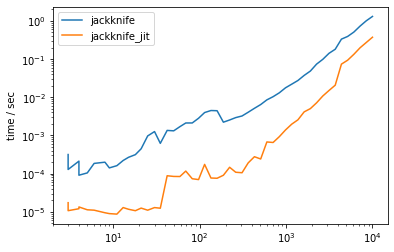

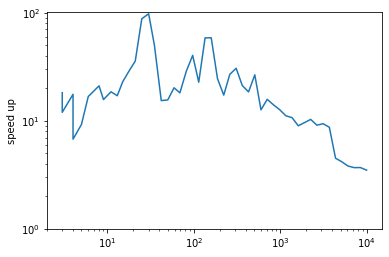

In [22]:
plt.figure()
for key, ts in times.items():
    plt.plot(n, ts, label=key)
plt.loglog()
plt.ylabel("time / sec")
plt.legend()

plt.figure()
plt.plot(n, times["jackknife"] / times["jackknife_jit"])
plt.ylim(1, None)
plt.ylabel("speed up")
plt.loglog();